# frac
fractional differentiation

In [3]:
import sys
import os
from os import sep
from os.path import dirname, realpath
from pathlib import Path
import logging
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

def get_cwd(fname, subdir, crunch_dir=realpath(Path.home()) +sep +'crunch' +sep):
    """
    Convenience function to make a directory string for the current file based on inputs.
    Jupyter Notebook in Anaconda invokes the Python interpreter in Anaconda's subdirectory
    which is why changing sys.argv[0] is necessary. In the future a better way to do this
    should be preferred..
    """
    return crunch_dir +subdir +fname
    
def fix_path(cwd):
    """
    Convenience function to fix argv and python path so that jupyter notebook can run the same as
    any script in crunch.
    """
    sys.argv[0] = cwd
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

fix_path(get_cwd('test.ipynb', 'recon' +sep))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit, vectorize
from dask import delayed, dataframe as dd

from ipywidgets import interact, interactive, fixed
from IPython.display import display

pd.set_option("display.max_rows", 100)
pd.set_option('display.max_columns', 50)

from common_util import query_df, search_df, chained_filter, list_get_dict, benchmark
from data.data_api import DataAPI
from data.access_util import df_getters as dg, col_subsetters as cs, col_subsetters2 as cs2
from mutate.common import dum
from mutate.fracdiff import *
from mutate.runt_util import *

### Load Data

In [2]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

search_terms = {
    'stage': 'raw',
    'raw_cat': 'us_equity_index'
}
date_range = {
    'id': ('lt', 2018)
}
dfs = {}
with benchmark('data load') as b:
    for rec, df in DataAPI.generate(search_terms):
        dfs[rec.name] = df.loc[search_df(df, date_range)]

print(', '.join(dfs.keys()))

INFO:root:data load : 92.5 seconds
dow_jones_raw_0, sp_500_raw_1, nasdaq_100_raw_2, russell_2000_raw_3


In [3]:
df = dfs['sp_500_raw_1']

In [8]:
pba_cols = chained_filter(df.columns, [cs['#pba']['ohlc']])
vol_cols = chained_filter(df.columns, [cs['#vol']['ohlc']])
trmi_v3_cols = chained_filter(df.columns, [cs['#trmi']['all']])
pba_vol_df = df.loc[:, pba_cols + vol_cols]

In [9]:
df_trmi = df[trmi_v3_cols]

In [11]:
for col in df_trmi.columns:
    print(col)

etf_v2_buzz_N
etf_v2_relativeBuzz_N
etf_v2_sentiment_N
etf_v2_optimism_N
etf_v2_fear_N
etf_v2_joy_N
etf_v2_trust_N
etf_v2_violence_N
etf_v2_conflict_N
etf_v2_gloom_N
etf_v2_stress_N
etf_v2_timeUrgency_N
etf_v2_uncertainty_N
etf_v2_emotionVsFact_N
etf_v2_longShort_N
etf_v2_longShortForecast_N
etf_v2_priceDirection_N
etf_v2_priceForecast_N
etf_v2_volatility_N
etf_v2_loveHate_N
etf_v2_anger_N
etf_v2_debtDefault_N
etf_v2_innovation_N
etf_v2_marketRisk_N
etf_v2_analystRating_N
etf_v2_dividends_N
etf_v2_earningsForecast_N
etf_v2_fundamentalStrength_N
etf_v2_layoffs_N
etf_v2_litigation_N
etf_v2_managementChange_N
etf_v2_managementTrust_N
etf_v2_mergers_N
etf_v2_buzz_S
etf_v2_relativeBuzz_S
etf_v2_sentiment_S
etf_v2_optimism_S
etf_v2_fear_S
etf_v2_joy_S
etf_v2_trust_S
etf_v2_violence_S
etf_v2_conflict_S
etf_v2_gloom_S
etf_v2_stress_S
etf_v2_timeUrgency_S
etf_v2_uncertainty_S
etf_v2_emotionVsFact_S
etf_v2_longShort_S
etf_v2_longShortForecast_S
etf_v2_priceDirection_S
etf_v2_priceForecast_S
etf_

In [28]:
pba_close_d = pba_vol_df[['pba_close']].resample('B').last()
si_buzz = df[['mkt_v3_stockIndexBuzz_N']].resample('BH')

In [18]:
si_buzz = df[['mkt_v3_stockIndexBuzz_N']]

In [21]:
si_buzz['diffed'] = si_buzz['mkt_v3_stockIndexBuzz_N'].diff(1)

/home/kevin/crunch/recon/test.ipynb:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
plot_min_FFD_ser(si_buzz[['mkt_v3_stockIndexBuzz_N']], 'mkt_v3_stockIndexBuzz_N', thresh=.01)

INFO:root:finished computing weights
DEBUG:root:[[1.]]


KeyboardInterrupt: 

INFO:root:finished computing weights
DEBUG:root:[[1.]]
INFO:root:finished computing weights
DEBUG:root:[[ 1.     -0.1    -0.045  -0.0285]]
INFO:root:finished computing weights
DEBUG:root:[[ 1.    -0.2   -0.08  -0.048]]
INFO:root:finished computing weights
DEBUG:root:[[ 1.     -0.3    -0.105  -0.0595]]
INFO:root:finished computing weights
DEBUG:root:[[ 1.    -0.4   -0.12  -0.064]]
INFO:root:finished computing weights
DEBUG:root:[[ 1.     -0.5    -0.125  -0.0625]]
INFO:root:finished computing weights
DEBUG:root:[[ 1.    -0.6   -0.12  -0.056]]
INFO:root:finished computing weights
DEBUG:root:[[ 1.     -0.7    -0.105  -0.0455]]
INFO:root:finished computing weights
DEBUG:root:[[ 1.    -0.8   -0.08  -0.032]]
INFO:root:finished computing weights
DEBUG:root:[[ 1.     -0.9    -0.045  -0.0165]]
INFO:root:finished computing weights
DEBUG:root:[[ 1. -1.]]


adf_stat         p_val  lags    n_obs  95%_conf  corr_coeff
0.0    0.052069  9.626321e-01   1.0  39848.0 -2.861613    1.000000
0.1   -0.684123  8.508194e-01   1.0  39841.0 -2.861613    0.999976
0.2   -1.890615  3.364890e-01   1.0  39840.0 -2.861613    0.999806
0.3   -3.440507  9.653117e-03   1.0  39840.0 -2.861613    0.999288
0.4   -5.271619  6.267651e-06   1.0  39840.0 -2.861613    0.998226
0.5   -7.812242  7.019505e-12   1.0  39840.0 -2.861613    0.995917
0.6  -11.554980  3.376052e-21   1.0  39840.0 -2.861613    0.990746
0.7  -15.728324  1.298596e-28   1.0  39842.0 -2.861613    0.982652
0.8  -24.854994  0.000000e+00   1.0  39843.0 -2.861613    0.956347
0.9  -37.657513  0.000000e+00   1.0  39845.0 -2.861613    0.903403
1.0 -179.260627  0.000000e+00   1.0  39847.0 -2.861613    0.014827

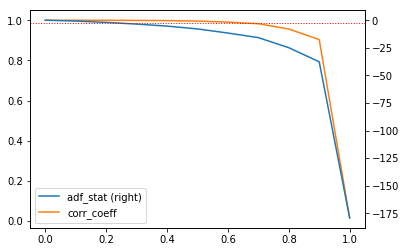

In [12]:
plot_min_FFD_ser(pba_vol_df[['pba_close']], 'pba_close', thresh=.01)

### Hist trading hours per day

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5a7f1aa940>]],
      dtype=object)

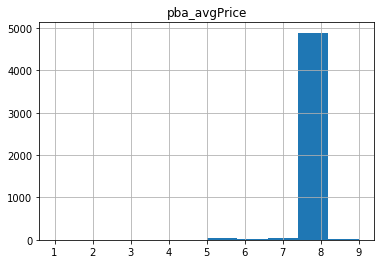

In [59]:
def agg_func(ser):
    nona = ser.dropna()
    if (not nona.empty):
        cnt = nona.count()
        return cnt
    return None

no_half_days = day_group[['pba_avgPrice']].apply(agg_func)
no_half_days.hist()

### 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5a7f2953c8>]],
      dtype=object)

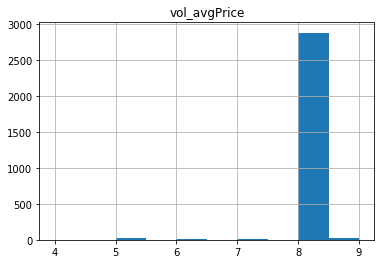

In [60]:
def agg_func(ser):
    nona = ser.dropna()
    if (not nona.empty):
        cnt = nona.count()
        return cnt
    return None

no_half_days_vol = day_group[['vol_avgPrice']].apply(agg_func)
no_half_days_vol.hist()

In [71]:
def hourly_count(ser):
    day_group = ser.groupby(pd.Grouper(freq='B'))
    return day_group.count()

dow_jones_raw_0


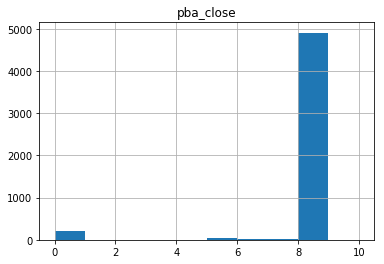

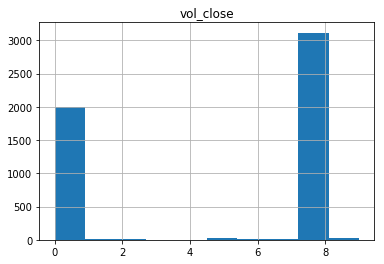

sp_500_raw_1


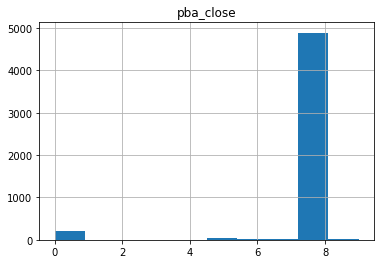

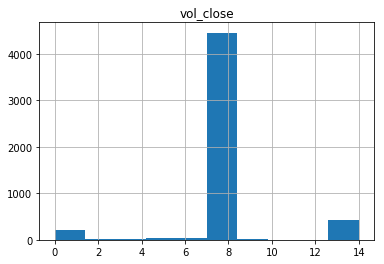

nasdaq_100_raw_2


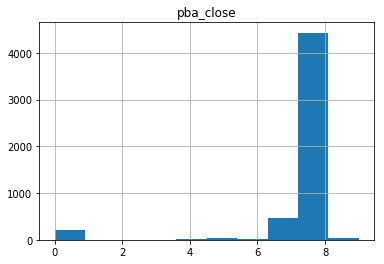

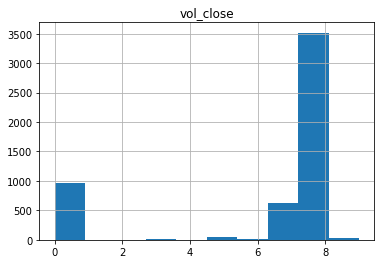

russell_2000_raw_3


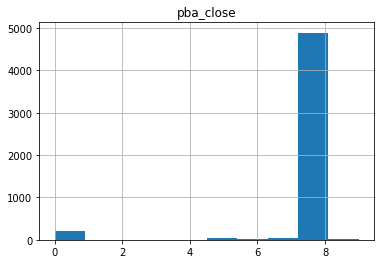

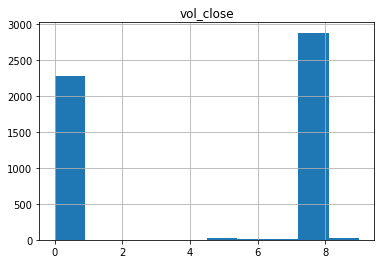

In [82]:
aspect = 'close'
for df_name, df in dfs.items():
    pba_cols = chained_filter(df.columns, [cs['#pba']['ohlc']])
    vol_cols = chained_filter(df.columns, [cs['#vol']['ohlc']])
    pba_vol_df = df.loc[:, pba_cols + vol_cols]
    print(df_name)
    
    plt.title('pba_' +aspect)
    hourly_count(pba_vol_df['pba_avgPrice']).hist()
    plt.show()
    
    plt.title('vol_' +aspect)
    hourly_count(pba_vol_df['vol_avgPrice']).hist()
    plt.show()
#     plt.title(df_name)
#     splt.show()
    
    

## Test Fracdiff runt transform

In [12]:
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

In [4]:
dr = ['srf', 'dr']
dr_dg, dr_cs = list_get_dict(dg, dr), list_get_dict(cs2, dr)
dr_paths, dr_recs, dr_dfs = DataAPI.load_from_dg(dr_dg, dr_cs)

In [14]:
variants = {
    "d": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0],
    "size": [None],
    "thresh": [1e-4, 1e-3, 1e-2, 1e-1],
    "method": ["FFD"]
}
if (meta['var_fmt'] == 'grid'):
    var_names, param_combos = list(var.keys()), list(product(*var.values()))
    variants = [{var_names[idx]: param_value for idx, param_value in enumerate(combo)} for combo in param_combos]

In [11]:
ser_fn = fracdiff
rtype_fn = apply_rt_df

In [15]:
for key_chain in dr_paths:
    src_df = list_get_dict(dr_dfs, key_chain).dropna(axis=0, how='all')

    for variant in variants:
        runted_df = rtype_fn(src_df, ser_fn(**variant), None)
        desc_sfx = meta['rec_fmt'].format(**variant)
        desc_pfx = get_desc_pfx(key_chain, src_rec)
        desc = '_'.join([desc_pfx, desc_sfx])

        if (meta['mtype_from']=='name'):       mutate_type = meta['name']
        elif (meta['mtype_from']=='rec_fmt'):  mutate_type = desc_sfx

        assert(not is_empty_df(runted_df))
        entry = make_runt_entry(desc, res_freq, mutate_type, src_rec)
        logging.info('dumping ' +desc +'...')
        logging.debug('post_transform: ' +str(runted_df))
    break

TypeError: dict object argument after ** must be a mapping, not str